# Notebook 02: Análisis Exploratorio y Limpieza


--- Análisis de Nulos Inicial (Total: 456,579 registros) ---


                           missing_%
referencia_del_contrato          0.0
departamento                     0.0
ciudad                           0.0
tipo_de_contrato                 0.0
modalidad_de_contratacion        0.0
estado_contrato                  0.0
sector                           0.0
orden                            0.0
valor_del_contrato               0.0
fecha_de_firma                   0.0
dias_adicionados                 0.0

--- Descriptivas Numéricas ---


                 variable       n  missing_%     mediana        p10  \
0  valor_del_contrato_num  441948        0.0  13500000.0  4400000.0   
1    dias_adicionados_num  441948        0.0         0.0        0.0   

          p90         iqr    ceros_%  
0  78000000.0  20760000.0   0.000000  
1        15.0         0.0  86.177559  

--- Top 10 por Categoría ---

Distribución de departamento:
+--------------------+------+
|        departamento| count|
+--------------------+------+
|Distrito Capital ...|109787|
|     Valle del Cauca| 56459|
|           Antioquia| 44809|
|           Santander| 23864|
|        Cundinamarca| 19700|
|           Magdalena| 17988|
|              Boyacá| 14495|
|           Atlántico| 14329|
|             Bolívar| 13913|
|                Meta| 13010|
+--------------------+------+
only showing top 10 rows


Distribución de tipo_de_contrato:
+--------------------+------+
|    tipo_de_contrato| count|
+--------------------+------+
|Prestación de ser...|351673|
|      


Proceso completado. Registros finales: 441,948


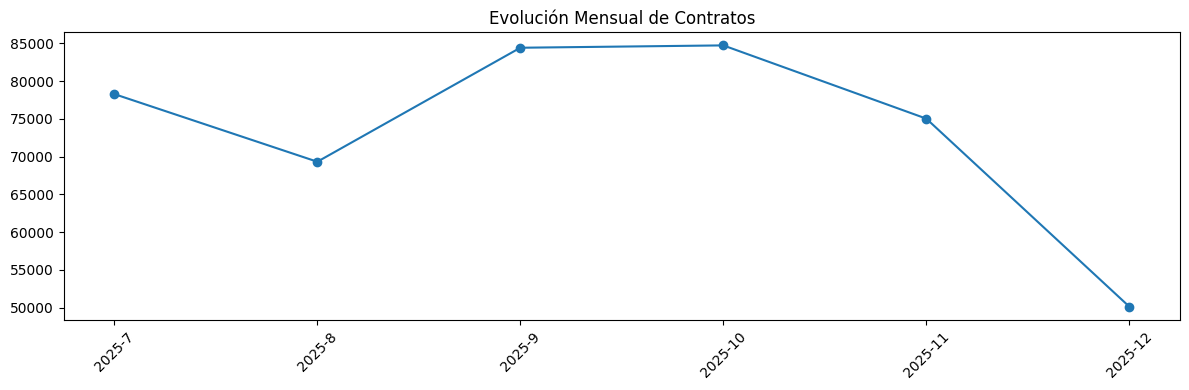

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. CONFIGURACIÓN E INICIO
spark = SparkSession.builder \
    .appName("SECOP_EDA_Completo") \
    .master("spark://spark-master:7077") \
    .config("spark.executor.memory", "2g") \
    .getOrCreate()

df_raw = spark.read.parquet("/opt/spark-data/raw/secop_contratos.parquet").cache()
total_inicial = df_raw.count()

# 2. CONTEO DE NULOS (ANTES DE FILTRAR)
print(f"\n--- Análisis de Nulos Inicial (Total: {total_inicial:,} registros) ---")
null_stats = df_raw.select([
    (F.count(F.when(F.col(c).isNull() | F.isnan(c), c)) / total_inicial * 100).alias(c)
    for c in df_raw.columns
]).toPandas().T
null_stats.columns = ['missing_%']
print(null_stats.sort_values('missing_%', ascending=False))

# 3. VALIDACIONES
fecha_limite = "1900-01-01"

# Preparación de tipos para validación
df = df_raw.withColumn("valor_del_contrato_num", F.col("valor_del_contrato").cast("double")) \
           .withColumn("dias_adicionados_num", F.col("dias_adicionados").cast("int")) \
           .withColumn("fecha_firma_dt", F.to_date("fecha_de_firma"))

# Aplicación de filtros solicitados
df_filtered = df.filter(
    (F.col("valor_del_contrato_num") > 0) & 
    (F.col("fecha_firma_dt").isNotNull()) &
    (F.col("fecha_firma_dt") >= fecha_limite) &
    (F.col("departamento").isNotNull()) &
    (F.upper(F.col("departamento")) != "NO DEFINIDO")
).fillna({"dias_adicionados_num": 0})

# 4. ESTADÍSTICAS DESCRIPTIVAS NUMÉRICAS AVANZADAS
def get_numeric_stats(df, col_names):
    stats_list = []
    n_total = df.count()
    
    for c in col_names:
        # Cálculo de percentiles y cuantiles para IQR
        quantiles = df.approxQuantile(c, [0.10, 0.25, 0.50, 0.75, 0.90], 0.05)
        p10, q1, mediana, q3, p90 = quantiles
        iqr = q3 - q1
        
        # Agregaciones en una sola pasada
        agg_res = df.select(
            F.count(c).alias("n"),
            F.count(F.when(F.col(c) == 0, True)).alias("ceros")
        ).collect()[0]
        
        stats_list.append({
            "variable": c,
            "n": agg_res["n"],
            "missing_%": ((n_total - agg_res["n"]) / n_total) * 100,
            "mediana": mediana,
            "p10": p10,
            "p90": p90,
            "iqr": iqr,
            "ceros_%": (agg_res["ceros"] / n_total) * 100
        })
    return pd.DataFrame(stats_list)

print("\n--- Descriptivas Numéricas ---")
num_cols = ["valor_del_contrato_num", "dias_adicionados_num"]
print(get_numeric_stats(df_filtered, num_cols))

# 5. DESCRIPTIVAS CATEGÓRICAS (TOP 10)
cat_cols = ["departamento", "tipo_de_contrato", "estado_contrato", "sector"]
print("\n--- Top 10 por Categoría ---")
for cat in cat_cols:
    print(f"\nDistribución de {cat}:")
    df_filtered.groupBy(cat).count().orderBy(F.desc("count")).show(10)

# 6. ANÁLISIS TEMPORAL
print("\n--- Análisis Temporal (Por Mes) ---")
df_time = df_filtered.withColumn("anio", F.year("fecha_firma_dt")) \
                     .withColumn("mes", F.month("fecha_firma_dt")) \
                     .groupBy("anio", "mes") \
                     .agg(F.count("*").alias("total_contratos"), 
                          F.avg("valor_del_contrato_num").alias("valor_promedio")) \
                     .orderBy("anio", "mes")

df_time.show(12)

# Visualización Temporal
pdf_time = df_time.toPandas()
pdf_time['periodo'] = pdf_time['anio'].astype(str) + "-" + pdf_time['mes'].astype(str)
plt.figure(figsize=(12, 4))
plt.plot(pdf_time['periodo'], pdf_time['total_contratos'], marker='o')
plt.xticks(rotation=45)
plt.title("Evolución Mensual de Contratos")
plt.tight_layout()
plt.savefig('/opt/spark-data/processed/eda_temporal.png')

# 7. GUARDADO FINAL
output_path = "/opt/spark-data/processed/secop_eda_final.parquet"
df_filtered.repartition(4).write.mode("overwrite").parquet(output_path)

print(f"\nProceso completado. Registros finales: {df_filtered.count():,}")
spark.stop()